In [1]:
# import libraries
import pandas as pd

# load the dataset big
#movies_df = pd.read_csv('ml-latest/movies.csv', low_memory=False)
#genome_score_df = pd.read_csv('ml-latest/genome-scores.csv', low_memory=False)
#genome_tags_df = pd.read_csv('ml-latest/genome-tags.csv', low_memory=False)
#links_df = pd.read_csv('ml-latest/links.csv', low_memory=False)
#ratings_df = pd.read_csv('ml-latest/ratings.csv', low_memory=False)
#tags_df = pd.read_csv('ml-latest/tags.csv', low_memory=False)

In [2]:
import pandas as pd
# load the dataset small
movies_df = pd.read_csv('ml-small/movies.csv')
ratings_df = pd.read_csv('ml-small/ratings.csv')
links_df = pd.read_csv('ml-small/links.csv')
tags_df = pd.read_csv('ml-small/tags.csv', low_memory=False)

In [3]:
print(movies_df.shape)
print(links_df.shape)
print(ratings_df.shape)
print(tags_df.shape)

(9742, 3)
(9742, 3)
(100836, 4)
(3683, 4)


In [4]:
#quick overview of datasets to look for potential key to merge df
print(movies_df.head())
print("\n")
print(links_df.head())
print("\n")
print(ratings_df.head())
print("\n")
print(tags_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


   

In [5]:
#drop timestamp from tags_df (avoid double timestamps)
tags_df.drop(columns='timestamp', inplace=True)

#merging all dataframes
full_df = movies_df.merge(ratings_df, left_on='movieId', right_on='movieId')
full_df = full_df.merge(links_df, left_on='movieId', right_on='movieId')
full_df = full_df.merge(tags_df, left_on='movieId', right_on='movieId')
full_df.shape

(233213, 10)

In [6]:
#check for merged df
full_df

,movieId,title,genres,userId_x,rating,timestamp,imdbId,tmdbId,userId_y,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar
...,...,...,...,...,...,...,...,...,...,...
233208,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,586,5.0,1529899556,3778644,348350.0,62,star wars
233209,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,184,3.5,1537098554,1636780,71172.0,184,anime
233210,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,184,3.5,1537098554,1636780,71172.0,184,comedy
233211,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,184,3.5,1537098554,1636780,71172.0,184,gintama


In [7]:
#information, looking for missing data or wrong dtypes
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 233212
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    233213 non-null  int64  
 1   title      233213 non-null  object 
 2   genres     233213 non-null  object 
 3   userId_x   233213 non-null  int64  
 4   rating     233213 non-null  float64
 5   timestamp  233213 non-null  int64  
 6   imdbId     233213 non-null  int64  
 7   tmdbId     233213 non-null  float64
 8   userId_y   233213 non-null  int64  
 9   tag        233213 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 19.6+ MB


## Create base functions

### Scored based on votes and ratings

In [8]:
# calculate average with count
avg_rating_df = full_df.groupby(['title'])['rating'].agg(['mean', 'count'])
avg_rating_df.rename(columns={'mean': 'vote_average', 'count': 'vote_count'}, inplace=True)
avg_rating_df.sort_values('vote_average', ascending=False).head(10)

# C is the mean vote or rating across the whole dataframe
C = avg_rating_df['vote_average'].mean()

# m is the minimum votes or ratings to be listed | using a low value because the dataset is small
m = avg_rating_df['vote_count'].quantile(0.80)
print('Numbers of votes to be in final list:', m)
# weight function (ranked based on number of votes AND score)
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

# check the new scores
avg_rating_df = avg_rating_df.copy().loc[avg_rating_df['vote_count'] >= m]
avg_rating_df['score'] = avg_rating_df.apply(weighted_rating, axis=1)

#list of top 10 movies with best "Scores"
avg_rating_df.sort_values('score', ascending=False).head(10)


Numbers of votes to be in final list: 92.0


,vote_average,vote_count,score
title,,,
"Shawshank Redemption, The (1994)",4.429022,1268,4.376483
Fight Club (1999),4.272936,11772,4.268123
Star Wars: Episode IV - A New Hope (1977),4.231076,6526,4.223031
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041,970,4.214705
"Departed, The (2006)",4.252336,1070,4.204834
"Usual Suspects, The (1995)",4.237745,1224,4.196822
Pulp Fiction (1994),4.197068,55567,4.196168
Schindler's List (1993),4.225000,1540,4.192719
Star Wars: Episode V - The Empire Strikes Back (1980),4.215640,2110,4.192106


In [9]:
#list of top 10 users with most ratings => trending users!
avg_rating_user = full_df.groupby(['userId_x'])['rating'].agg(['mean', 'count'])
avg_rating_user.rename(columns={'mean': 'vote_average', 'count': 'vote_count'}, inplace=True)
avg_rating_user.sort_values('vote_count', ascending=False).head(10)

,vote_average,vote_count
userId_x,,
474,3.778004,2455
414,4.134016,2343
599,3.480476,2100
68,3.183696,1791
610,4.310994,1701
274,3.811111,1665
249,4.188685,1635
448,3.636508,1575
380,4.250651,1536


### Create Combinations and occurance of pairwise!

In [10]:
from itertools import permutations
# create a function that makes combinations of the movie that a user (x) reviewed
def create_combinations(x):
    combinations = pd.DataFrame(list(permutations(x.values, 2)), columns=['item_a', 'item_b'])
    return combinations


In [11]:
#number of users
print(len(full_df['userId_x'].unique()))

#number of movies
len(full_df['title'].unique())

610


1554

In [12]:
#avoid users with only 60 review to measure impact 
avg_user = full_df.groupby(['userId_x']).size().reset_index(name='counts')
avg_user = avg_user[avg_user['counts'] > 100]
avg_user.sort_values(by='counts', ascending=False)

,userId_x,counts
473,474,2455
413,414,2343
598,599,2100
67,68,1791
609,610,1701
...,...,...
454,455,105
270,271,104
328,329,103
184,185,102


In [13]:
# use the create_combinations function
movie_combinations = full_df.groupby('userId_x')['title'].apply(create_combinations)
movie_combinations = movie_combinations.reset_index(drop=True)
combi_count = movie_combinations.groupby(['item_a', 'item_b']).size()
combi_count = combi_count.to_frame(name='size').reset_index()

#remove duplicates (same movie iteam_a and b)
combi_count['equal'] = combi_count['item_a'] == combi_count["item_b"]
combi_count = combi_count[combi_count['equal'] == False]
combi_count.drop(columns='equal', inplace=True) #remove this ugly name!

#sort by size!
combi_count.sort_values('size', ascending=False)

,item_a,item_b,size
1356930,Pulp Fiction (1994),Fight Club (1999),1544292
553767,Fight Club (1999),Pulp Fiction (1994),1544292
1357781,Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),724724
1643533,Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),724724
1009061,Léon: The Professional (a.k.a. The Professiona...,Pulp Fiction (1994),684180
...,...,...,...
685262,"Great Santini, The (1979)",Being Julia (2004),1
1518035,Shadowlands (1993),Billy Elliot (2000),1
1518034,Shadowlands (1993),"Bill Cosby, Himself (1983)",1
1518032,Shadowlands (1993),Bill & Ted's Bogus Journey (1991),1


In [14]:
#Similarities based on a text search for example and a default parameter
search_box = "Star Wars"
minium_size = 30 #users who watched item_a, watched item_b

test_names = combi_count[( combi_count['item_a'].str.contains(search_box) ) & (combi_count['size'] > minium_size)]
test_names.sort_values(by='size', ascending=False)

,item_a,item_b,size
1643533,Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),724724
1645074,Star Wars: Episode V - The Empire Strikes Back...,Pulp Fiction (1994),251590
1642900,Star Wars: Episode IV - A New Hope (1977),Fight Club (1999),188136
1642474,Star Wars: Episode IV - A New Hope (1977),2001: A Space Odyssey (1968),90610
1643263,Star Wars: Episode IV - A New Hope (1977),Léon: The Professional (a.k.a. The Professiona...,77350
...,...,...,...
1584789,Solo: A Star Wars Story (2018),"Shawshank Redemption, The (1994)",32
1640940,Star Wars: Episode III - Revenge of the Sith (...,10 Cloverfield Lane (2016),32
1584651,Solo: A Star Wars Story (2018),Old Boy (2003),32
1640883,Star Wars: Episode I - The Phantom Menace (1999),When We Were Kings (1996),32


In [15]:
#test some recommendation based of ocurrance

#variable defined by user 
#film_name = input('Type the name of your movie:')

#to run 1st time without pausing
film_name = "Star Wars: Episode VI - Return of the Jedi (1983)"
common_movies = combi_count[combi_count['item_a'] == film_name].sort_values("size", ascending=False).head(5)
#common_movies = common_movies['item_b']
#common_movies = common_movies.rename(columns={"item_b": "Movie_Names"})
common_movies = common_movies.reset_index(drop=True)

print("These are the 5 movies that users who watched {}, rated:".format(film_name))
#merge rating informations (Dataset create before and using list of name as a input)

#remember scores = number of votes and rates!!
scores = avg_rating_df["score"].loc[common_movies['item_b']]
common_movies['score'] = scores.values
#common_movies.drop(columns='equal', inplace=True)
common_movies.sort_values("score", ascending=False).head(5)


These are the 5 movies that users who watched Star Wars: Episode VI - Return of the Jedi (1983), rated:


,item_a,item_b,size,score
1,Star Wars: Episode VI - Return of the Jedi (1983),Fight Club (1999),16848,4.268123
2,Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode IV - A New Hope (1977),13650,4.223031
0,Star Wars: Episode VI - Return of the Jedi (1983),Pulp Fiction (1994),66246,4.196168
4,Star Wars: Episode VI - Return of the Jedi (1983),Léon: The Professional (a.k.a. The Professiona...,7665,4.011695
3,Star Wars: Episode VI - Return of the Jedi (1983),2001: A Space Odyssey (1968),9348,3.889611


In [74]:
avg_rating_df

,vote_average,vote_count,score
title,,,
(500) Days of Summer (2009),3.666667,336,3.663592
101 Dalmatians (1996),3.074468,94,3.360308
12 Angry Men (1957),4.149123,513,4.073582
2001: A Space Odyssey (1968),3.894495,4469,3.889611
28 Days Later (2002),3.974138,116,3.831813
...,...,...,...
X-Men: The Last Stand (2006),3.355769,104,3.494986
X2: X-Men United (2003),3.723684,380,3.709782
You've Got Mail (1998),3.120000,100,3.375090


### Similarities between Genres or Users

In [16]:
# remove duplicates
full_df2 = full_df.copy().drop_duplicates(subset=['title'])

# cast to list
full_df2['genres'] = full_df2.genres.str.split('|').tolist()
#full_df2['genres'].head(10)

# explode into rows
full_df2 = full_df2.explode('genres')
#full_df2.head(5)

# let's make a crosstab
movies_category = pd.crosstab(full_df2['title'], full_df2['genres'])
movies_category


genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...And Justice for All (1979),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
10 Cloverfield Lane (2016),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10 Things I Hate About You (1999),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
101 Dalmatians (1996),0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
Zombieland (2009),0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Zoolander (2001),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
#user similarities vs genres

# remove duplicates
full_df3 = full_df.copy().drop_duplicates(subset=['title'])

full_df3['genres'] = full_df3['genres'].str.split('|').tolist()

# explode into rows
full_df3 = full_df3.explode('genres')
#full_df3.head(5)

# let's make a crosstab
users_category = pd.crosstab(full_df3['userId_x'], full_df3['genres'])
users_category


genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId_x,,,,,,,,,,,,,,,,,,,,
1,0,41,37,14,16,39,28,0,40,20,1,7,0,10,12,15,25,28,9,3
2,0,8,2,0,0,3,8,1,12,0,0,1,4,0,2,1,3,6,1,1
3,0,1,1,2,2,6,1,0,11,1,0,0,0,1,0,5,0,0,3,0
4,0,5,8,2,3,36,14,1,62,3,3,2,1,5,11,30,2,16,5,4
5,0,4,4,2,5,5,3,0,11,2,0,0,2,2,0,5,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
560,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
567,1,0,2,3,0,2,0,0,9,2,0,4,0,0,2,2,2,3,0,0


In [18]:
#Or we can have users by movies similarities

# remove duplicates
full_df4 = full_df.copy()

# let's make a crosstab
users_movies = pd.crosstab(full_df4['userId_x'], full_df3['title'])
users_movies


title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
userId_x,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
movies_category

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...And Justice for All (1979),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
10 Cloverfield Lane (2016),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10 Things I Hate About You (1999),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
101 Dalmatians (1996),0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
Zombieland (2009),0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Zoolander (2001),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Distances Similarities (Jaccard)

In [19]:
# import necessary stuff
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

#movies distances based on genres
# calculate the distances
jaccard_distances = pdist(movies_category.values, metric='jaccard')
square_jaccard_distances = squareform(jaccard_distances)

#square_jaccard_distances
jaccard_similarity_array = 1 - square_jaccard_distances
#jaccard_similarity_array

distance_df_movies_category = pd.DataFrame(jaccard_similarity_array, index=movies_category.index, columns=movies_category.index)
distance_df_movies_category


title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),1.000000,0.250000,0.000000,0.666667,0.200000,0.0,0.333333,0.333333,0.200000,0.500000,...,0.250000,0.200000,1.000000,0.666667,0.333333,0.200000,0.200000,0.333333,0.20,0.000000
...And Justice for All (1979),0.250000,1.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.500000,0.666667,0.000000,...,0.000000,0.666667,0.250000,0.333333,0.000000,0.666667,0.000000,0.000000,0.25,0.250000
10 Cloverfield Lane (2016),0.000000,0.500000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,...,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.00,0.333333
10 Things I Hate About You (1999),0.666667,0.000000,0.000000,1.000000,0.250000,0.0,0.000000,0.000000,0.000000,0.666667,...,0.333333,0.000000,0.666667,0.333333,0.500000,0.000000,0.250000,0.500000,0.00,0.000000
101 Dalmatians (1996),0.200000,0.000000,0.000000,0.250000,1.000000,0.5,0.000000,0.000000,0.200000,0.200000,...,0.250000,0.000000,0.200000,0.000000,0.333333,0.000000,0.200000,0.333333,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0.200000,0.666667,0.333333,0.000000,0.000000,0.0,0.333333,0.333333,0.500000,0.000000,...,0.000000,0.500000,0.200000,0.250000,0.000000,1.000000,0.200000,0.000000,0.50,0.500000
Zombieland (2009),0.200000,0.000000,0.000000,0.250000,0.200000,0.0,0.000000,0.000000,0.000000,0.200000,...,0.250000,0.000000,0.200000,0.000000,0.333333,0.200000,1.000000,0.333333,0.20,0.200000
Zoolander (2001),0.333333,0.000000,0.000000,0.500000,0.333333,0.0,0.000000,0.000000,0.000000,0.333333,...,0.500000,0.000000,0.333333,0.000000,1.000000,0.000000,0.333333,1.000000,0.00,0.000000


In [20]:
#list top 10 similar movies:
movie_name = "Zombieland (2009)"

distance_df_movies_category[movie_name].sort_values(ascending=False).head(11) #because the first element is the movie

title
Zombieland (2009)                                       1.000000
Game Night (2018)                                       0.750000
Tucker & Dale vs Evil (2010)                            0.666667
Rare Exports: A Christmas Tale (Rare Exports) (2010)    0.666667
Jaws 3-D (1983)                                         0.666667
Jaws (1975)                                             0.666667
Get Smart (2008)                                        0.666667
The Interview (2014)                                    0.666667
Once Bitten (1985)                                      0.666667
Observe and Report (2009)                               0.666667
My Demon Lover (1987)                                   0.666667
Name: Zombieland (2009), dtype: float64

In [21]:
# calculate the distances | change a bit to be easier to change the cross_tab input

#users distances based on genres/categories
cross_tab = users_category
jaccard_distances = pdist(cross_tab.values, metric='jaccard')
square_jaccard_distances = squareform(jaccard_distances)

#square_jaccard_distances
jaccard_similarity_array = 1 - square_jaccard_distances
#jaccard_similarity_array

distance_df = pd.DataFrame(jaccard_similarity_array, index=cross_tab.index, columns=cross_tab.index)
distance_df

userId_x,1,2,3,4,5,6,7,8,9,10,...,462,465,474,477,509,514,560,567,594,606
userId_x,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.058824,0.000000,...,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,0.0,1.000000,0.000000,0.052632,0.000000,0.055556,0.052632,0.000000,0.000000,0.111111,...,0.066667,0.000000,0.000000,0.200000,0.000000,0.071429,0.00,0.117647,0.071429,0.071429
3,0.0,0.000000,1.000000,0.052632,0.214286,0.066667,0.058824,0.000000,0.066667,0.071429,...,0.083333,0.000000,0.055556,0.000000,0.090909,0.000000,0.00,0.000000,0.000000,0.000000
4,0.0,0.052632,0.052632,1.000000,0.052632,0.105263,0.052632,0.000000,0.000000,0.157895,...,0.000000,0.000000,0.157895,0.052632,0.000000,0.000000,0.00,0.050000,0.000000,0.000000
5,0.0,0.000000,0.214286,0.052632,1.000000,0.062500,0.058824,0.000000,0.133333,0.214286,...,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.00,0.062500,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,0.0,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.100000,0.000000,1.000000,0.00,0.000000,0.000000,0.000000
560,0.0,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.055556,0.100000,0.333333,0.000000,1.00,0.000000,0.250000,0.000000
567,0.0,0.117647,0.000000,0.050000,0.062500,0.000000,0.000000,0.000000,0.000000,0.058824,...,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.00,1.000000,0.000000,0.000000


In [22]:
#list top 10 similar users: 
user_number = 474 #top 1 user with most ratings
distance_df[user_number].sort_values(ascending=False).head(11) #because the first element is the user

userId_x
474    1.000000
17     0.157895
4      0.157895
105    0.111111
45     0.111111
371    0.111111
509    0.111111
82     0.111111
7      0.105263
64     0.105263
103    0.105263
Name: 474, dtype: float64

In [23]:
# calculate the distances | change a bit to be easier to change the cross_tab input

#users distances based on Movies
cross_tab = users_movies
jaccard_distances = pdist(cross_tab.values, metric='jaccard')
square_jaccard_distances = squareform(jaccard_distances)

#square_jaccard_distances
jaccard_similarity_array = 1 - square_jaccard_distances
#jaccard_similarity_array

distance_df = pd.DataFrame(jaccard_similarity_array, index=cross_tab.index, columns=cross_tab.index)
distance_df

userId_x,1,2,3,4,5,6,7,8,9,10,...,462,465,474,477,509,514,560,567,594,606
userId_x,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
users_movies.loc[users_movies.index == 474]

title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
userId_x,,,,,,,,,,,,,,,,,,,,,
474,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [25]:
#list top 10 similar users: As we can see similarities with users based on movies has a too sparce matrix
user_number = 474 #top 1 user with most ratings
distance_df[user_number].sort_values(ascending=False).head(11) #because the first element is the user


userId_x
474    1.0
606    0.0
64     0.0
84     0.0
82     0.0
79     0.0
74     0.0
70     0.0
68     0.0
66     0.0
63     0.0
Name: 474, dtype: float64

### Cosine Similarities

In [26]:
full_df.head()

,movieId,title,genres,userId_x,rating,timestamp,imdbId,tmdbId,userId_y,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar


In [27]:
#select a subset of fields only
smaller_selection = full_df.groupby(['title', 'tag', 'genres']).size().reset_index(name='counts')
#smaller_selection = smaller_selection[smaller_selection['counts'] > 2]
smaller_selection = smaller_selection.reset_index().drop_duplicates()
smaller_selection.shape
smaller_selection


,index,title,tag,genres,counts
0,0,(500) Days of Summer (2009),Funny,Comedy|Drama|Romance,42
1,1,(500) Days of Summer (2009),Zooey Deschanel,Comedy|Drama|Romance,42
2,2,(500) Days of Summer (2009),artistic,Comedy|Drama|Romance,42
3,3,(500) Days of Summer (2009),humorous,Comedy|Drama|Romance,42
4,4,(500) Days of Summer (2009),inspiring,Comedy|Drama|Romance,42
...,...,...,...,...,...
3553,3553,Zoolander (2001),comedy,Comedy,54
3554,3554,Zoolander (2001),goofy,Comedy,54
3555,3555,Zoolander (2001),mindless one liners,Comedy,54
3556,3556,Zulu (1964),Africa,Action|Drama|War,4


In [28]:
#example of how many tags a movie have
smaller_selection[smaller_selection['title']=="Toy Story (1995)"].groupby('tag')['title'].count()

tag
fun      1
pixar    1
Name: title, dtype: int64

In [29]:
#need to group tags in one row
smaller_selection_tag = smaller_selection.copy()
# concatenate the string 
smaller_selection_tag['tag'] = smaller_selection_tag.groupby(['title'])['tag'].transform(lambda x : ' '.join(x)) 
  
# drop duplicate data

#smaller_selection_tag.drop(columns=['index', 'counts'], inplace=True)
smaller_selection_tag = smaller_selection_tag.drop_duplicates(subset=['title'])  
smaller_selection_tag.reset_index(inplace=True)

# show the dataframe 
smaller_selection_tag

,level_0,index,title,tag,genres,counts
0,0,0,(500) Days of Summer (2009),Funny Zooey Deschanel artistic humorous inspir...,Comedy|Drama|Romance,42
1,8,8,...And Justice for All (1979),lawyers,Drama|Thriller,3
2,9,9,10 Cloverfield Lane (2016),creepy suspense,Thriller,14
3,11,11,10 Things I Hate About You (1999),Shakespeare sort of,Comedy|Romance,54
4,12,12,101 Dalmatians (1996),dogs remake,Adventure|Children|Comedy,47
...,...,...,...,...,...,...
1549,3539,3539,Zero Dark Thirty (2012),Afghanistan American propaganda assassination ...,Action|Drama|Thriller,14
1550,3544,3544,Zombieland (2009),Bill Murray Emma Stone Jesse Eisenberg Woody H...,Action|Comedy|Horror,53
1551,3550,3550,Zoolander (2001),David Bowie Will Ferrell ben stiller comedy go...,Comedy,54
1552,3556,3556,Zulu (1964),Africa,Action|Drama|War,4


In [30]:
# import TfidfVectorize
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

smaller_selection_tag['tag'] = smaller_selection_tag['tag'].fillna('')

tfidf_matrix = tfidf.fit_transform(smaller_selection_tag['tag'])

tfidf_matrix.shape


(1554, 1671)

In [31]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [32]:
indices = pd.Series(smaller_selection_tag.index, index=smaller_selection_tag['title']).drop_duplicates()
indices

title
(500) Days of Summer (2009)             0
...And Justice for All (1979)           1
10 Cloverfield Lane (2016)              2
10 Things I Hate About You (1999)       3
101 Dalmatians (1996)                   4
                                     ... 
Zero Dark Thirty (2012)              1549
Zombieland (2009)                    1550
Zoolander (2001)                     1551
Zulu (1964)                          1552
eXistenZ (1999)                      1553
Length: 1554, dtype: int64

In [33]:
indices['Zoolander (2001)']


1551

In [34]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return smaller_selection_tag.iloc[movie_indices]

In [35]:
#variable defined by user 
#film_name = input('Type the name of your movie:')
film_name = "101 Dalmatians (1996)"

print('Your movie tags: \n{}'.format(smaller_selection_tag["tag"].iloc[indices[film_name]]))
print('Your movie genre: \n{}'.format(smaller_selection_tag["genres"].iloc[indices[film_name]]))
get_recommendations(film_name)

Your movie tags: 
dogs remake
Your movie genre: 
Adventure|Children|Comedy


,level_0,index,title,tag,genres,counts
1432,3311,3311,Turner & Hooch (1989),dogs,Comedy|Crime,13
581,1378,1378,"Haunting, The (1999)",remake,Horror|Thriller,13
1161,2703,2703,Sabrina (1995),remake,Comedy|Romance,54
1452,3373,3373,"Vanishing, The (1993)",remake,Mystery|Thriller,4
135,358,358,Best in Show (2000),Dogs satire,Comedy,53
430,1039,1039,Father of the Bride (1991),remake wedding,Comedy,13
431,1041,1041,Father of the Bride Part II (1995),pregnancy remake,Comedy,49
1231,2851,2851,Silk Stockings (1957),Ninotchka remake,Musical,1
1543,3531,3531,You've Got Mail (1998),e-mail remake,Comedy|Romance,50
1358,3139,3139,The Count of Monte Cristo (2002),Dumas remake revenge,Action|Adventure|Drama|Thriller,32


In [36]:
#after see the results, only tags dont see to work => A comedy movie and a Horror movie dosent seems right match... So lets try to mix with genre as well!


# Ideias

1. Which movies are most watched(rated) all the time? - OK done first part
2. Who is the user that watched the most number of movies? - - OK done first part
3. Graph of Genres (barplot) with avg ratings, and top movie by each genre!
4. Genres that a user NEVER watch but is well rated -> include diversity!
5. Clusterize all users: detect similar preferences! It is possible to aquire or simulate "random" demographics: age, sex,... ? - OK done first part Cluster users by similaritity in genre and movies rated

# Similar Functions of previous methods

In [37]:
def expand_colum(df, column_name, field='title'):
    """ transform a colum with stacked values in a crosstab colum """
    # remove duplicates
    df2 = df.drop_duplicates(subset=['title'])

    # get rid of those pesky []'s and '
    #full_df2['genres2'] = full_df2.genres.apply(lambda x: x.replace('|', ''))
    #full_df2['genres2'] = full_df2.genres.apply(lambda x: x.replace(']', ''))
    #full_df2['genres2'] = full_df2.genres.apply(lambda x: x.replace("'", ""))

    # cast to list
    if df2[column_name].dtype == "int64":
        df2[column_name] = df2[column_name].tolist()
    else:
        df2[column_name] = df2[column_name].str.split('|').tolist()
    # explode into rows
    df = df2.explode(column_name)
    
    # let's make a crosstab
    df_column = pd.crosstab(df[field], df[column_name])
    df_column
    
    #return one df with columns by row (util to average statistics for example)
    #return a crosstab table
    return df, df_column

def calc_distance(cross_df):
    """ receive a crosstab df and return a distance dataframe"""
    # import necessary stuff
    from sklearn.metrics import jaccard_score
    from scipy.spatial.distance import pdist, squareform

    # calculate the distances
    jaccard_distances = pdist(cross_df.values, metric='jaccard')
    square_jaccard_distances = squareform(jaccard_distances)

    #square_jaccard_distances
    jaccard_similarity_array = 1 - square_jaccard_distances
    #jaccard_similarity_array
    distance_df = pd.DataFrame(jaccard_similarity_array, index=cross_df.index, columns=cross_df.index)
    return distance_df

def get_similarities(distance_df, col_name, numbers=5):
    """receive a distance df and film_name/user_number, and return a list of "numbers" films"""
    #variable defined by user 
    #film_name = input('Type the name of your movie:')
    print('Top {} Similar with {}'.format(numbers,col_name))
    print(distance_df[col_name].sort_values(ascending=False).head(numbers))
    
def create_combinations(x):
    """to be used inside another functions as apply method"""
    from itertools import permutations

    # create a function that makes combinations of the movie that a user (x) reviewed
    
    combinations = pd.DataFrame(list(permutations(x.values, 2)), columns=['item_a', 'item_b'])
    return combinations

def create_combination_df(df, col_filter='userId_x', col_group='title'):
    # use the create_combinations function
    movie_combinations = df.groupby(col_filter)[col_group].apply(create_combinations)

    movie_combinations = movie_combinations.reset_index(drop=True)
    combi_count = movie_combinations.groupby(['item_a', 'item_b']).size()
    combi_count = combi_count.to_frame(name='size').reset_index()

    #remove duplicates (same movie iteam_a and b)
    combi_count['equal'] = combi_count['item_a'] == combi_count["item_b"]
    combi_count = combi_count[combi_count['equal'] == False]

    combi_count.sort_values('size', ascending=False)
    return combi_count

def cosine_similatirity(df, col_filter='tag'):
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import linear_kernel
    #create object and define stop words language
    tfidf = TfidfVectorizer(stop_words='english')

    #fill na if exists
    df[col_filter] = df[col_filter].fillna('')

    #transform based on object tfidf
    tfidf_matrix = tfidf.fit_transform(df[col_filter])
    
    #apply functions
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()
    
    #return indices and df of similarities
    return indices, cosine_sim


### NEED FIX #####
def get_recommendations_cos(title, df, indices, cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    print('Your movie tags: \n{}'.format(df["tag"].iloc[df[title]]))
    print('Your movie genre: \n{}'.format(df["genres"].iloc[df[title]]))
    # Return the top 10 most similar movies
    return df.iloc[movie_indices]

def weight_votes(df, group_col, agg_col1='vote_average', agg_col2='vote_count', number=10):
    # calculate average with count
    #avg_rating_df = df.groupby([group_col])[agg_col].agg(['mean', 'count'])
       # avg_rating_df.rename(columns={'mean': 'vote_average', 'count': 'vote_count'}, inplace=True)
    #avg_rating_df.sort_values('vote_average', ascending=False).head(10)

    # C is the mean vote or rating across the whole dataframe
    C = df['vote_average'].mean()

    # m is the minimum votes or ratings to be listed | using a low value because the dataset is small
    m = df['vote_count'].quantile(0.10)

    # weight function (ranked based on number of votes AND score)
    def weighted_rating(x, m=m, C=C):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)

    # check the new scores
    avg_rating_df = df.copy().loc[df['vote_count'] >= m]
    avg_rating_df['score'] = avg_rating_df.apply(weighted_rating, axis=1)
    avg_rating_df = avg_rating_df.sort_values('score', ascending=False).head(number)
    return avg_rating_df

def concat_field(df, col_name):
    """ receive a df and a column name, concat multiple rows on that column, for example all rows with different tags"""
    #need to group columns in one row #example tag
   
    # concatenate the string 
    df[col_name] = df.groupby(['title'])[col_name].transform(lambda x : ' '.join(x)) 

    # drop duplicate data | not using because i prefer df with all rows, so u can made the statics better

    #smaller_selection_tag.drop(columns=['index', 'counts'], inplace=True)
    #smaller_selection_tag = smaller_selection_tag.drop_duplicates(subset=['tag'])  
    #smaller_selection_tag.reset_index(inplace=True)

    # show the dataframe 
    return smaller_selection_tag

def create_date_of_ratings(df, col_name):
    pass

# Rating Movies and how update the database

In [38]:
#create function to rate a movie and update database
def rating_movie(df, title, rating):
    pass

#update all tables metrics: like distances tables, main database, scores...
#it should run on backgroung to avoid user experience being compromised
def update_tables():
    pass


# Content Based Recommender

### Recommends content similar to the content the user has consumed in the past

In [39]:
#get top 5 movies by genre | we can use it later to define other parameters

#explode genres column
full_df_genres, full_df_cross = expand_colum(full_df, "genres")

#look for user top genre

full_df_genres

<ipython-input-37-d1f3d5b1bf1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column_name] = df2[column_name].str.split('|').tolist()


,movieId,title,genres,userId_x,rating,timestamp,imdbId,tmdbId,userId_y,tag
0,1,Toy Story (1995),Adventure,1,4.0,964982703,114709,862.0,336,pixar
0,1,Toy Story (1995),Animation,1,4.0,964982703,114709,862.0,336,pixar
0,1,Toy Story (1995),Children,1,4.0,964982703,114709,862.0,336,pixar
0,1,Toy Story (1995),Comedy,1,4.0,964982703,114709,862.0,336,pixar
0,1,Toy Story (1995),Fantasy,1,4.0,964982703,114709,862.0,336,pixar
...,...,...,...,...,...,...,...,...,...,...
233199,187595,Solo: A Star Wars Story (2018),Sci-Fi,62,4.0,1528934550,3778644,348350.0,62,Emilia Clarke
233209,193565,Gintama: The Movie (2010),Action,184,3.5,1537098554,1636780,71172.0,184,anime
233209,193565,Gintama: The Movie (2010),Animation,184,3.5,1537098554,1636780,71172.0,184,anime
233209,193565,Gintama: The Movie (2010),Comedy,184,3.5,1537098554,1636780,71172.0,184,anime


In [40]:
#Ratings by user per genres
users_genre = full_df_genres.groupby(by=["userId_x","genres"])["rating"].agg(['mean', "count"]).reset_index()
users_genre.rename(columns={'mean': 'vote_average', 'count': 'vote_count'}, inplace=True)
users_genre

,userId_x,genres,vote_average,vote_count
0,1,Action,4.317073,41
1,1,Adventure,4.432432,37
2,1,Animation,4.642857,14
3,1,Children,4.625000,16
4,1,Comedy,4.333333,39
...,...,...,...,...
948,594,Comedy,4.500000,1
949,594,Drama,4.500000,1
950,594,Romance,4.500000,1
951,606,Drama,3.750000,2


In [41]:
#get top 5 movies by genre | we can use it later to define other parameters
#first look for the highest rank genre for one user
user_number = 10
user_genre = users_genre[ (users_genre['userId_x'] == user_number) ] 

#sort_values by score (composite of rating and number of votes)
user_genre = weight_votes(user_genre, "genres")
print(user_genre)

user_genre.sort_values(by=("score"), ascending=False, inplace=True)

print("Your favorite genre is: {}". format(user_genre["genres"].iloc[0]))
print("Score of this genre: {:.2f}". format(user_genre["score"].iloc[0]))
print("Number of rated movies of this genre: {}". format(user_genre["vote_count"].iloc[0]))
#assign to a variable
genre = user_genre["genres"].iloc[0]

     userId_x     genres  vote_average  vote_count     score
129        10   Thriller      4.333333           3  3.960103
127        10    Romance      3.541667          12  3.498379
119        10  Animation      3.750000           2  3.493468
123        10      Drama      3.464286          14  3.433232
121        10     Comedy      3.115385          13  3.113877
117        10     Action      3.000000           4  3.024235
125        10       IMAX      3.000000           4  3.024235
118        10  Adventure      2.928571           7  2.955234
124        10    Fantasy      2.833333           3  2.913592
120        10   Children      2.666667           3  2.797313
Your favorite genre is: Thriller
Score of this genre: 3.96
Number of rated movies of this genre: 3


In [42]:
#filter in data_set movies that he already watched
filter_user = full_df_genres[ (full_df_genres['genres'] == genre) & (full_df_genres['userId_x'] == user_number) ] 
filter_user

,movieId,title,genres,userId_x,rating,timestamp,imdbId,tmdbId,userId_y,tag
207502,54286,"Bourne Ultimatum, The (2007)",Thriller,10,3.5,1455356320,440963,2503.0,166,assassin
212053,63992,Twilight (2008),Thriller,10,4.5,1455356863,1099212,8966.0,62,audience intelligence underestimated
225491,96079,Skyfall (2012),Thriller,10,5.0,1455302172,1074638,37724.0,567,beautiful cinematography


In [43]:
#list of all movies from selected genre
index = full_df_genres[["title", "genres"]][full_df_genres['genres'] == genre]
full_df_genres[["title", "genres"]][full_df_genres['genres'] == genre]

,title,genres
1666,Get Shorty (1995),Thriller
1755,Copycat (1995),Thriller
2016,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Thriller
5063,To Die For (1995),Thriller
5110,Seven (a.k.a. Se7en) (1995),Thriller
...,...,...
232711,John Wick: Chapter Two (2017),Thriller
232892,It Comes at Night (2017),Thriller
232894,Black Mirror: White Christmas (2014),Thriller
232914,Dunkirk (2017),Thriller


In [44]:
#list of all movies from selected genre that user DONT watch yet
filter_user_not = full_df_genres[ (full_df_genres['genres'] == genre) & (full_df_genres['userId_x'] != user_number) ] 
filter_user_not = filter_user_not.groupby(by=["title","genres"])["rating"].agg(['mean', "count"]).reset_index()
filter_user_not.rename(columns={'mean': 'vote_average', 'count': 'vote_count'}, inplace=True)

#as dataset is small there is basic one vote by movie
filter_user_not = weight_votes(filter_user_not, "genres", number=1000)
filter_user_not.sort_values(by="score", ascending=False)

,title,genres,vote_average,vote_count,score
229,"Spanish Prisoner, The (1997)",Thriller,5.0,1,4.32699
94,Funny Games U.S. (2007),Thriller,5.0,1,4.32699
68,Dolores Claiborne (1995),Thriller,5.0,1,4.32699
23,Black Mirror: White Christmas (2014),Thriller,5.0,1,4.32699
230,Speed (1994),Thriller,5.0,1,4.32699
...,...,...,...,...,...
24,Black Swan (2010),Thriller,1.0,1,2.32699
272,"Village, The (2004)",Thriller,1.0,1,2.32699
259,"Time to Kill, A (1996)",Thriller,1.0,1,2.32699
244,"Talented Mr. Ripley, The (1999)",Thriller,1.0,1,2.32699


In [45]:
#Crate a ratings by genre
ratings_genre = full_df_genres.groupby(by=["genres"])["rating"].agg(['mean', "count"]).reset_index()
ratings_genre.rename(columns={'mean': 'vote_average', 'count': 'vote_count'}, inplace=True)
ratings_genre = weight_votes(ratings_genre, "genres", number=100)
ratings_genre.sort_values(by="score", ascending=False)

,genres,vote_average,vote_count,score
10,Film-Noir,3.939394,33,3.829958
7,Documentary,3.878788,66,3.825889
13,Musical,3.803571,84,3.778611
14,Mystery,3.774809,131,3.762445
3,Animation,3.752941,85,3.741244
6,Crime,3.737745,204,3.733929
8,Drama,3.681766,872,3.682609
18,War,3.664474,76,3.676515
17,Thriller,3.660959,292,3.665233
9,Fantasy,3.638655,119,3.652339


In [46]:
#Recommend the 10 movies similar to the best movie for this user

In [47]:
#Select 3 most relevant genres based on user rating (Score = weighted between avg and number of votes)

In [48]:
#Select 3 most relevant tags based on user rating (Score = weighted between avg and number of votes)

In [49]:
#recommend 5 movies based on this criterias

In [50]:
#recommend 5 movies based on this criterias

In [51]:
#Recommend the 10 movies based to the last movie for this user

# Collaborative Filtering

### Users who are similar to the target user have consumed

In [52]:
#explode users column to build user similarities
full_df_users, full_df_cross = expand_colum(full_df, "userId_x")
full_df_cross

<ipython-input-37-d1f3d5b1bf1e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column_name] = df2[column_name].tolist()


userId_x,1,2,3,4,5,6,7,8,9,10,...,462,465,474,477,509,514,560,567,594,606
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...And Justice for All (1979),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10 Cloverfield Lane (2016),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10 Things I Hate About You (1999),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101 Dalmatians (1996),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zombieland (2009),0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zoolander (2001),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:

user = 10
#select a film to test

#create oone crosstab by genres and other by users similatires
users = "userId_x"
genres = "genres"
x1, df_cross_users = expand_colum(full_df, users) #x1 -> only if we have colum with sepators like "|"
genre_rows, df_cross_genres = expand_colum(full_df, genres)

#create distances matrices
df_dist_users = calc_distance(df_cross_users )
df_dist_genres = calc_distance(df_cross_genres)
df_dist_users



<ipython-input-37-d1f3d5b1bf1e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column_name] = df2[column_name].tolist()
<ipython-input-37-d1f3d5b1bf1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column_name] = df2[column_name].str.split('|').tolist()


title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All (1979),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Cloverfield Lane (2016),1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Zombieland (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Zoolander (2001),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [54]:
#top 5 movies based on users similarities
print("similatires based user")
users_similarities = get_similarities(df_dist_users, film_name, numbers=5)
print("\n")
print("similatires based on  genre")
genres_similarities = get_similarities(df_dist_genres, film_name, numbers=5)

similatires based user
Top 5 Similar with 101 Dalmatians (1996)
title
Stripes (1981)                                                       1.0
Scream 2 (1997)                                                      1.0
Meatballs (1979)                                                     1.0
Christmas Vacation (National Lampoon's Christmas Vacation) (1989)    1.0
Christmas Story, A (1983)                                            1.0
Name: 101 Dalmatians (1996), dtype: float64


similatires based on  genre
Top 5 Similar with 101 Dalmatians (1996)
title
Big Top Pee-Wee (1988)                                    1.00
101 Dalmatians (1996)                                     1.00
Finding Nemo (2003)                                       0.75
Bug's Life, A (1998)                                      0.75
Lemony Snicket's A Series of Unfortunate Events (2004)    0.75
Name: 101 Dalmatians (1996), dtype: float64


# Colababorative Filtering v2

How do you determine which users or items are similar to one another?

Given that you know which users are similar, how do you determine the rating that a user would give to an item based on the ratings of similar users?

How do you measure the accuracy of the ratings you calculate?

One important thing to keep in mind is that in an approach based purely on collaborative filtering, the similarity is not calculated using factors like the age of users, genre of the movie, or any other data about users or items. It is calculated only on the basis of the rating (explicit or implicit) a user gives to an item. For example, two users can be considered similar if they give the same ratings to ten movies despite there being a big difference in their age.

## Memory Based

To find the rating R that a user U would give to an item I, the approach includes:

1.Finding users similar to U who have rated the item I 

2.Calculating the rating R based the ratings of users found in the previous step

In [55]:
# Using Cosine distances

# With the similarity factor S for each user similar to the target user U, you can calculate the weighted average using this formula:
#Sum(Ru*Su)/Sum(Su)


## Model Based

### Singular Value Decomposition (SVD)

In [56]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, GridSearchCV
reader = Reader()
ratings_df.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [57]:
#Evaluate the best error metric
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cv = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)
cv

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8639  0.8677  0.8534  0.8720  0.8674  0.8676  0.8837  0.8532  0.8752  0.8674  0.8672  0.0087  
MAE (testset)     0.6606  0.6655  0.6557  0.6704  0.6612  0.6652  0.6778  0.6557  0.6749  0.6650  0.6652  0.0070  
Fit time          4.77    4.71    4.85    5.09    5.26    4.86    4.88    4.96    4.98    4.78    4.91    0.16    
Test time         0.07    0.06    0.07    0.06    0.06    0.07    0.06    0.06    0.07    0.07    0.06    0.00    


{'test_rmse': array([0.86387063, 0.86772738, 0.85342318, 0.87204765, 0.86739283,
        0.86761463, 0.88368668, 0.85320115, 0.87519477, 0.8673868 ]),
 'test_mae': array([0.66063352, 0.66552638, 0.65574208, 0.67036258, 0.66117934,
        0.66521532, 0.67784609, 0.65570425, 0.67487042, 0.66499524]),
 'fit_time': (4.765706300735474,
  4.712652921676636,
  4.850507497787476,
  5.086302757263184,
  5.2580180168151855,
  4.8631792068481445,
  4.882952690124512,
  4.957134962081909,
  4.984218597412109,
  4.775887727737427),
 'test_time': (0.06982922554016113,
  0.061836957931518555,
  0.06622505187988281,
  0.06482601165771484,
  0.06283116340637207,
  0.06578493118286133,
  0.05684828758239746,
  0.06382870674133301,
  0.06582450866699219,
  0.07081055641174316)}

In [58]:
#improve parameters with grid search
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8935713516937897
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [59]:
#Training using the best estimator
svd = gs.best_estimator['rmse']
svd.fit(data.build_full_trainset())

In [60]:
#Look for movies that a user has watched
user_watched = ratings_df[ratings_df['userId'] == 474]
user_watched.rename(columns={"userId": "userId_x"}, inplace=True) #need to latter concat with existing DF :()
user_watched.drop(columns='timestamp', inplace=True)
user_watched

C:\Users\hansf\anaconda3\lib\site-packages\pandas\core\frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\hansf\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,userId_x,movieId,rating
73092,474,1,4.0
73093,474,2,3.0
73094,474,5,1.5
73095,474,6,3.0
73096,474,7,3.0
...,...,...,...
75195,474,55814,4.0
75196,474,56563,3.5
75197,474,56607,3.5
75198,474,63433,4.0


In [61]:
#Recommend 5 movies to a user based on most similar to user
users = 474
#find most similar users
x1, genres_df = expand_colum(full_df, "genres", field='userId_x')
dist_user_genres = calc_distance(genres_df)
get_similarities(dist_user_genres, users)


Top 5 Similar with 474
userId_x
474    1.000000
17     0.157895
4      0.157895
105    0.111111
45     0.111111
Name: 474, dtype: float64


<ipython-input-37-d1f3d5b1bf1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column_name] = df2[column_name].str.split('|').tolist()


In [62]:
#find the top 5 high score movies of that user
users_sim = 17
list_movies = full_df [ (full_df["userId_x"] == users_sim) & (full_df["userId_x"] != users)][["userId_x","movieId", "rating", ]].sort_values(by="rating", ascending=False).drop_duplicates()
list_movies

,userId_x,movieId,rating
80584,17,318,5.0
26385,17,296,5.0
119011,17,1210,5.0
131155,17,1732,5.0
186790,17,6350,5.0
...,...,...,...
102811,17,910,3.5
210645,17,60069,3.5
101691,17,899,3.5
128010,17,1466,3.0


In [63]:
#To visualize if need to post what movies were ranked by user == 17 that user 474 not rated!
list_movies_3 = pd.concat([user_watched, list_movies])

filtered = pd.pivot_table(list_movies_3, values=['rating', "movieId"], index=['movieId'],
                    columns=['userId_x'])
#filtered.reset_index().sort_values(by=('rating',474), ascending=False)

#how to filter multi_index ??? need to fix it!
filtered

rating     
userId_x    17   474
movieId             
1           4.5  4.0
2           NaN  3.0
5           NaN  1.5
6           NaN  3.0
7           NaN  3.0
...         ...  ...
68157       4.0  NaN
68358       4.5  NaN
79132       4.5  NaN
80463       4.0  NaN
82459       4.0  NaN

[2116 rows x 2 columns]

In [64]:
#predict the score of our user from that 5 movies:
list_movies_2 = [79132,80463,82459] #added the movies by hand!
predictions = []
for i in list_movies_2:
    temp = svd.predict(users, i, 3)
    predictions.append((temp.iid,temp.est))
predictions

#We can look that based on similarities based on user 17 (most similar than user 474 our interested user), the movie 318 has the most chance to fit well to user 474

[(79132, 3.965207352174837),
 (80463, 3.8617421808145074),
 (82459, 3.7954752132999423)]

# News Content

### Recomends the TRENDING 

In [65]:
#recommend the TRENDING movie based on other similar users choices

#Define dates and number of rates on last month movies, ranked by score
# Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

def convert_time_stam(df):
    full_df2 = df.copy()
    full_df2['year'] = pd.to_datetime(full_df2.timestamp, unit='s', infer_datetime_format=True)
    full_df2['year'] = full_df2.year.dt.year
    full_df2['month'] = pd.to_datetime(full_df2.timestamp, unit='s', infer_datetime_format=True)
    full_df2['month'] = full_df2.month.dt.month
    return full_df2

full_df2 = convert_time_stam(full_df)
full_df2.head()

,movieId,title,genres,userId_x,rating,timestamp,imdbId,tmdbId,userId_y,tag,year,month
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar,2000,7
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar,2000,7
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun,2000,7
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar,1996,11
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar,1996,11


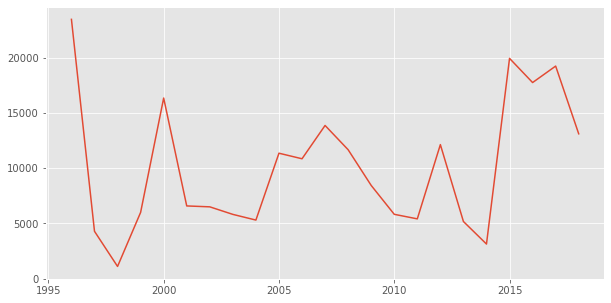

In [66]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#plot number of movies by year!
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(full_df2.movieId.groupby(full_df2["year"]).count())
plt.show()

In [67]:
def get_trend_movies(df_time_converted):
    """ method to return trend, input = df_with timestamp to date (year and month) """
    #get last date
    last = df_time_converted.sort_values(by=['year', "month"], ascending=False)
    last = last.reset_index(drop=True)
    year = last.iloc[0]['year']
    month = last.iloc[0]['month']
    print("year", year)
    print("month", month)

    #chose the last 5 movies (inverse index!!!)
    last_df = df_time_converted[ (df_time_converted['year'] == year) & (df_time_converted['month'] == month)]
    list_names_trend = last_df.groupby('title')['rating'].mean().sort_values().index[-5:]
    return list_names_trend

list_movies = get_trend_movies(full_df2)
list_movies

year 2018
month 9


Index(['Goodfellas (1990)', 'Shawshank Redemption, The (1994)',
       'In Bruges (2008)', 'Dark Knight, The (2008)',
       'Burn After Reading (2008)'],
      dtype='object', name='title')

In [68]:
#maybe just rated movies by friends??
friends = [ 474, 17] #using the same users from last section
friends_df = full_df2[full_df2["userId_x"].isin(friends)]
get_trend_movies(friends_df)


year 2012
month 1


Index(['My Neighbor Totoro (Tonari no Totoro) (1988)', 'Taxi Driver (1976)',
       'Raging Bull (1980)'],
      dtype='object', name='title')

## Diverse

In [69]:
#recommend the TRENDING movie based on DIVERSITY choices
#I need the SVD to made prediction to that user

user = 474
df = full_df.copy()

def get_genres(df, user):
    #return genres never watched 
    df_expanded, x2 = expand_colum(df, "genres") #expand genres columns to rows. x2 = is the crosstab! 
    dif_user = df_expanded[df_expanded['userId_x'] != user]['genres'].unique()
    same_user = df_expanded[df_expanded['userId_x'] == user]['genres'].unique()
    list_genres = list(set(dif_user)-set(same_user)) #as first set is a list of ALL other users i'assuming it is large array that a single user
    return list_genres

def get_movies(df, genres, user):
    #suggest one movie by each genre based on predict raking (SVD())
    df_expanded, x2 = expand_colum(df, "genres") #expand genres columns to rows. x2 = is the crosstab! 
    list_movies = df_expanded[ (df_expanded['userId_x'] != user) & (df_expanded['genres'].isin(genres) ) ]
    return list_movies





In [70]:
df_expanded, x2 = expand_colum(df, "genres")
genres = get_genres(full_df, user)
genres

<ipython-input-37-d1f3d5b1bf1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column_name] = df2[column_name].str.split('|').tolist()
<ipython-input-37-d1f3d5b1bf1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column_name] = df2[column_name].str.split('|').tolist()


['(no genres listed)', 'Sci-Fi']

In [71]:
get_movies(full_df, genres, user)

<ipython-input-37-d1f3d5b1bf1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[column_name] = df2[column_name].str.split('|').tolist()


,movieId,title,genres,userId_x,rating,timestamp,imdbId,tmdbId,userId_y,tag
1902,29,"City of Lost Children, The (Cité des enfants p...",Sci-Fi,23,4.0,1107341574,112682,902.0,474,kidnapping
2016,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Sci-Fi,4,2.0,945173447,114746,63.0,424,time travel
10965,160,Congo (1995),Sci-Fi,6,5.0,845553457,112715,10329.0,474,Michael Crichton
12542,260,Star Wars: Episode IV - A New Hope (1977),Sci-Fi,1,5.0,964981680,76759,11.0,63,classic
19235,273,Mary Shelley's Frankenstein (Frankenstein) (1994),Sci-Fi,6,3.0,845553875,109836,3036.0,600,gothic
...,...,...,...,...,...,...,...,...,...,...
232894,174053,Black Mirror: White Christmas (2014),Sci-Fi,62,5.0,1525637282,3973198,374430.0,62,Dystopia
232953,176371,Blade Runner 2049 (2017),Sci-Fi,25,4.0,1535470469,1856101,335984.0,567,atmospheric
233163,187593,Deadpool 2 (2018),Sci-Fi,25,5.0,1535470534,5463162,383498.0,62,Josh Brolin
233199,187595,Solo: A Star Wars Story (2018),Sci-Fi,62,4.0,1528934550,3778644,348350.0,62,Emilia Clarke


In [72]:
df_expanded[df_expanded["userId_x"] == user ]['genres'].unique()

array(['Comedy', 'Drama', 'Romance', 'Musical', 'Film-Noir', 'Mystery',
       'Thriller', 'Adventure', 'Crime', 'War', 'Documentary', 'Children',
       'Animation', 'IMAX', 'Western', 'Fantasy', 'Action', 'Horror'],
      dtype=object)